In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

Data preprocessing

In [2]:
path = "data/returns.csv"
returns = pd.read_csv(path, index_col=0, parse_dates=True)
returns.head()

,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.0,-0.070776,-0.037313,0.0,0.0,0.000000,-0.011139,0.0,0.0,-0.072165,...,0.025162,-0.003195,0.0,-0.032197,0.0,0.038682,-0.040040,0.0,0.000000,0.0
2001-01-03,0.0,0.103194,0.013566,0.0,0.0,0.100840,0.020025,0.0,0.0,0.094444,...,-0.043478,-0.051282,0.0,0.056751,0.0,0.107670,0.033368,0.0,0.000000,0.0
2001-01-04,0.0,0.037862,0.032505,0.0,0.0,0.041985,-0.082209,0.0,0.0,-0.081218,...,-0.027859,-0.064189,0.0,0.001852,0.0,-0.003995,-0.020182,0.0,-0.011628,0.0
2001-01-05,0.0,-0.054721,-0.018519,0.0,0.0,-0.040293,-0.034759,0.0,0.0,-0.104972,...,0.004525,0.010830,0.0,-0.031423,0.0,-0.029412,-0.011329,0.0,0.000000,0.0
2001-01-08,0.0,-0.032917,0.015094,0.0,0.0,0.011450,0.060942,0.0,0.0,-0.185185,...,-0.004505,0.030357,0.0,-0.005725,0.0,-0.015152,0.002083,0.0,0.017647,0.0


additional cleaning

In [3]:
def mask_pre_ipo(df):
    # For each stock, treat leading zeros as NA
    df2 = df.copy()
    for col in df2:
        s = df2[col]
        first_nonzero = s.ne(0).idxmax()  # first non-zero return
        df2.loc[:first_nonzero, col] = np.nan
    return df2

def safe_rolling_zscore(df, window):
    rolling_mean = df.rolling(window).mean()
    rolling_std = df.rolling(window).std()

    # If std == 0 → return 0 instead of NaN or inf
    z = (df - rolling_mean) / rolling_std.replace(0, np.nan)
    z = z.fillna(0)

    return z


# 1. Mask pre-IPO zeros  
returns = mask_pre_ipo(returns)

# 2. Compute stable rolling z  
features = safe_rolling_zscore(returns, window=60)

# 3. Replace infinities / residual NaN  
features = features.replace([np.inf, -np.inf], 0).fillna(0)


In [4]:
returns = features

# Assume `returns` is a (T, N) pandas DataFrame, indexed by date
X_all = torch.tensor(returns.shift(1).iloc[1:].values, dtype=torch.float32)  # r_t
y_all = torch.tensor(returns.iloc[1:].values, dtype=torch.float32)           # r_{t+1}
T, N = X_all.shape

# --------------- Train/Test Split (preserve order) ---------------
split_idx = int(T * 0.8)
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]


### data augmenting X_train and y_train

In [17]:

from augmentation import stationary_bootstrap

train_df = returns[:split_idx]
bootstrap_size = 100000
bootstrap_train_df = stationary_bootstrap(
    traindf=train_df,
    sample_size=30000,
    avg_block_length=30.0,
    random_state=42
)
bootstrap_train_df

,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
0,0.0,0.219754,0.496639,0.0,0.610914,0.680450,0.0,0.0,-0.250121,-0.574803,...,-0.299574,-0.351941,0.0,1.466143,0.0,0.273834,-0.102016,-0.099556,0.000000,0.0
1,0.0,-0.560952,-1.031761,0.0,0.237185,-0.319240,0.0,0.0,-1.107008,-0.024308,...,-0.975533,-0.882725,0.0,-0.575094,0.0,-0.977468,-1.210121,-0.887747,0.000000,0.0
2,0.0,0.291923,0.424001,0.0,-0.897410,0.638428,0.0,0.0,-0.239326,0.438071,...,1.028767,0.904784,0.0,-0.286002,0.0,0.473928,-0.091570,0.192380,0.000000,0.0
3,0.0,-0.800612,-0.643506,0.0,0.539256,-0.981341,0.0,0.0,-0.738657,-0.312708,...,-0.328511,-1.556646,0.0,-0.833047,0.0,-1.892448,-1.337448,-0.145646,0.000000,0.0
4,0.0,0.602839,0.882381,0.0,-0.027100,0.679096,0.0,0.0,0.286656,-0.844829,...,0.411540,-0.289323,0.0,0.739162,0.0,0.422906,-0.416310,0.223668,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,-0.308821,-0.886228,0.0,-1.199893,-0.603034,0.0,0.0,-4.549880,0.264639,...,-0.958309,-0.397657,0.0,-2.199963,0.0,-0.708453,-1.158092,-2.134548,-0.885810,0.0
29996,0.0,-0.593141,-2.700300,0.0,-1.327309,-0.183940,0.0,0.0,0.177101,-1.147738,...,-2.582342,-1.974437,0.0,0.570114,0.0,-0.959377,-1.058947,-2.799510,-0.876753,0.0
29997,0.0,2.209497,0.126291,0.0,-0.436704,1.710133,0.0,0.0,-2.344187,-1.037641,...,-1.829295,0.014473,0.0,-1.424303,0.0,0.489082,0.216944,-0.330632,-0.524469,0.0
29998,0.0,0.604342,-0.260589,0.0,0.399330,-1.040218,0.0,0.0,1.358663,0.857010,...,-0.863833,0.804359,0.0,-0.742007,0.0,-0.770257,-0.354198,0.875837,0.186862,0.0


In [18]:
X_train = torch.tensor(bootstrap_train_df.shift(1).iloc[1:].values, dtype=torch.float32)  # r_t
y_train = torch.tensor(bootstrap_train_df.iloc[1:].values, dtype=torch.float32)   

In [19]:

# --------------- Normalize using training set only ---------------

# mean = X_train.mean(0, keepdim=True)
# std = X_train.std(0, keepdim=True) + 1e-6
# X_train = (X_train - mean) / std
# y_train = (y_train - mean) / std
# X_test = (X_test - mean) / std
# y_test = (y_test - mean) / std

# --------------- Neural Network Definition ---------------
class ReturnPredictor(nn.Module):
    def __init__(self, N, hidden_dim=256, depth=3, dropout=0.1):
        super().__init__()
        layers = []
        in_dim = N
        for _ in range(depth):
            layers += [
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden_dim)
            ]
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, N))  # output dimension N
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = ReturnPredictor(N, hidden_dim=3, depth=2)
# Custom loss combining MSE and hit rate
def combined_loss(y_pred, y_true, mse_weight=0.5, hit_weight=100):
    # MSE component
    mse = torch.mean((y_pred - y_true) ** 2)
    
    # Hit rate component (penalize incorrect sign predictions)
    # We want to maximize hit rate, so we minimize (1 - hit_rate)
    correct_signs = (torch.sign(y_pred) == torch.sign(y_true)).float()
    hit_rate = torch.mean(correct_signs)
    hit_loss = 1 - hit_rate
    
    # Normalize MSE to be on similar scale as hit_loss (which is in [0, 1])
    # Use detach to avoid affecting gradients of the normalization factor
    mse_normalized = mse / (mse.detach() + 1e-8)
    
    # Combined loss with normalized components
    return mse_weight * mse_normalized + hit_weight * hit_loss

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --------------- Training Loop ---------------
n_epochs = 100
batch_size = 32
T_train = len(X_train)

for epoch in range(n_epochs):
    total_loss = 0
    for i in range(0, T_train, batch_size):
        Xb = X_train[i:i+batch_size]
        yb = y_train[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(Xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(Xb)
    if (epoch+1) % 10 == 0:
        avg_loss = total_loss / T_train
        print(f"Epoch {epoch+1:03d} | Train Loss {avg_loss:.6f}")

# --------------- Evaluation ---------------
with torch.no_grad():
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum().item()
    ss_tot = ((y_true)**2).sum().item()
    return 1 - ss_res / ss_tot

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)

print(f"\nTrain R² = {r2_train:.4f}")
print(f" Test R² = {r2_test:.4f}")

# --------------- Convert predictions back to DataFrame ---------------
# y_hat_test = (y_pred_test * std + mean).numpy()
# pred_df = pd.DataFrame(
#     y_hat_test,
#     index=returns.index[1:][split_idx:],
#     columns=returns.columns
# )

Epoch 010 | Train Loss 0.684083
Epoch 020 | Train Loss 0.676848
Epoch 030 | Train Loss 0.671624
Epoch 040 | Train Loss 0.669789
Epoch 050 | Train Loss 0.666560
Epoch 060 | Train Loss 0.666531
Epoch 070 | Train Loss 0.665135
Epoch 080 | Train Loss 0.662802
Epoch 090 | Train Loss 0.662988
Epoch 100 | Train Loss 0.663354

Train R² = 0.0885
 Test R² = -0.0690


In [7]:
# --------------- Hit Rate Calculation ---------------
# Hit rate: percentage of times the predicted sign matches the actual sign
def hit_rate(y_true, y_pred):
    correct = ((y_true * y_pred) > 0).sum().item()
    total = y_true.numel()
    return correct / total

hit_rate_train = hit_rate(y_train, y_pred_train)
hit_rate_test = hit_rate(y_test, y_pred_test)

print(f"\nTrain Hit Rate = {hit_rate_train:.4f}")
print(f" Test Hit Rate = {hit_rate_test:.4f}")



Train Hit Rate = 0.4429
 Test Hit Rate = 0.3851


### temporary sharpe calculation

strategy: long the top 10 positive expected return and short the 10 negative expected return

In [ ]:
raw_returns = pd.read_csv('data/returns.csv', index_col=0, parse_dates=True)
raw_returns.head()

,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.0,-0.070776,-0.037313,0.0,0.0,0.000000,-0.011139,0.0,0.0,-0.072165,...,0.025162,-0.003195,0.0,-0.032197,0.0,0.038682,-0.040040,0.0,0.000000,0.0
2001-01-03,0.0,0.103194,0.013566,0.0,0.0,0.100840,0.020025,0.0,0.0,0.094444,...,-0.043478,-0.051282,0.0,0.056751,0.0,0.107670,0.033368,0.0,0.000000,0.0
2001-01-04,0.0,0.037862,0.032505,0.0,0.0,0.041985,-0.082209,0.0,0.0,-0.081218,...,-0.027859,-0.064189,0.0,0.001852,0.0,-0.003995,-0.020182,0.0,-0.011628,0.0
2001-01-05,0.0,-0.054721,-0.018519,0.0,0.0,-0.040293,-0.034759,0.0,0.0,-0.104972,...,0.004525,0.010830,0.0,-0.031423,0.0,-0.029412,-0.011329,0.0,0.000000,0.0
2001-01-08,0.0,-0.032917,0.015094,0.0,0.0,0.011450,0.060942,0.0,0.0,-0.185185,...,-0.004505,0.030357,0.0,-0.005725,0.0,-0.015152,0.002083,0.0,0.017647,0.0


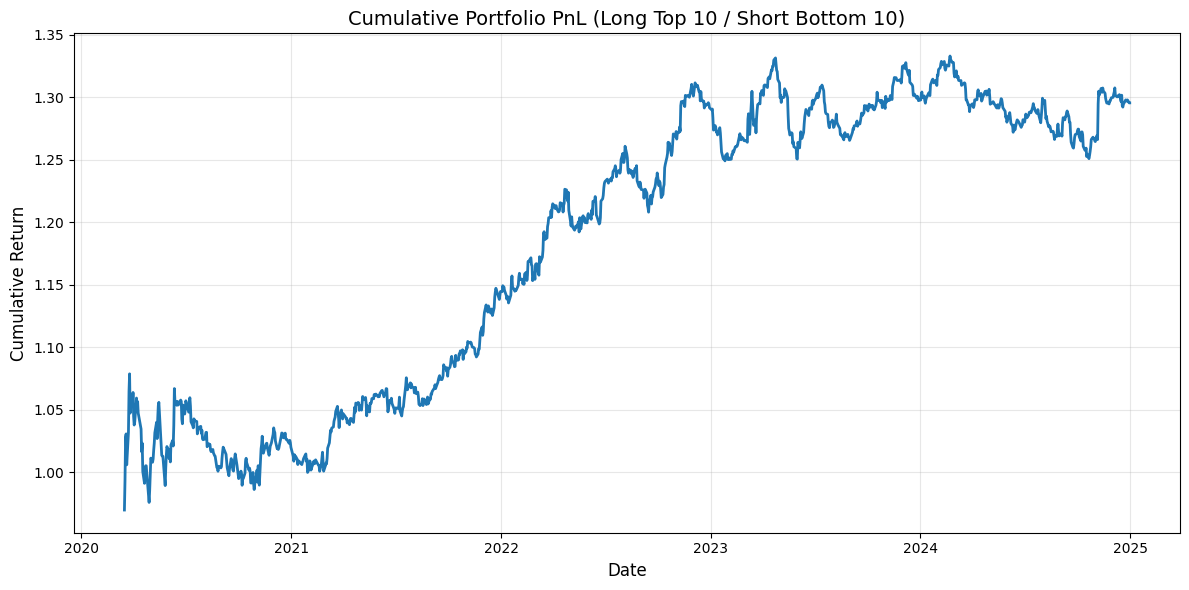


--- Portfolio Performance ---
Total Return: 0.2955 (29.55%)
Annualized Return: 0.0555 (5.55%)
Annualized Volatility: 0.0814 (8.14%)
Sharpe Ratio: 0.6814


In [25]:
# --------------- Portfolio Strategy Evaluation ---------------
# Strategy: Long top 10 positive predictions, short top 10 negative predictions

# Convert predictions back to DataFrame format
y_pred_test_np = y_pred_test.numpy()
test_dates = raw_returns.index[1:][split_idx:]
pred_df = pd.DataFrame(
    y_pred_test_np,
    index=test_dates,
    columns=raw_returns.columns
)

# Align actual returns with predictions
actual_returns = raw_returns.loc[test_dates]

# Initialize portfolio returns
portfolio_returns = []

for date in pred_df.index:
    # Get predictions for this date
    predictions = pred_df.loc[date]
    
    # Get top 10 positive predictions (long)
    top_long = predictions.nlargest(50)
    
    # Get top 10 negative predictions (short)
    top_short = predictions.nsmallest(50)
    
    # Calculate portfolio return for this date
    # Long positions: equal weight
    long_return = actual_returns.loc[date, top_long.index].mean()
    
    # Short positions: equal weight (negative of actual return)
    short_return = -actual_returns.loc[date, top_short.index].mean()
    
    # Total portfolio return (50% long, 50% short)
    portfolio_return = 0.5 * long_return + 0.5 * short_return
    portfolio_returns.append(portfolio_return)

# Convert to Series
portfolio_returns = pd.Series(portfolio_returns, index=pred_df.index)

# Calculate cumulative PnL
cumulative_pnl = (1 + portfolio_returns).cumprod()

# Plot the PnL
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl.index, cumulative_pnl.values, linewidth=2)
plt.title('Cumulative Portfolio PnL (Long Top 10 / Short Bottom 10)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate performance metrics
total_return = cumulative_pnl.iloc[-1] - 1
annualized_return = (1 + total_return) ** (252 / len(portfolio_returns)) - 1
volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / volatility if volatility > 0 else 0

print(f"\n--- Portfolio Performance ---")
print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Return: {annualized_return:.4f} ({annualized_return*100:.2f}%)")
print(f"Annualized Volatility: {volatility:.4f} ({volatility*100:.2f}%)")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
